# Detect disturbed tress

## Packages and Data

In [94]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from scipy.stats import pointbiserialr

In [96]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

In [97]:
calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

## Analysis stdv of indices 

In [98]:
index = "b5"
df_notdisturbed = df[df["is_disturbed"] == False]
df_yearly = df_notdisturbed.groupby(["id", "year"])[index].mean().reset_index()
std_df = (
    df_yearly.groupby("id")[index]
    .std()
    .reset_index()
    .sort_values(index, ascending=False)
)
std_df

,id,b5
15231,17514,2137.165164
8628,9953,2122.861891
12176,14017,1067.726455
5359,6186,939.373637
19882,22851,773.451698
...,...,...
3728,4319,3.927008
22333,25645,3.804370
947,1093,3.395503
15761,18120,3.182037


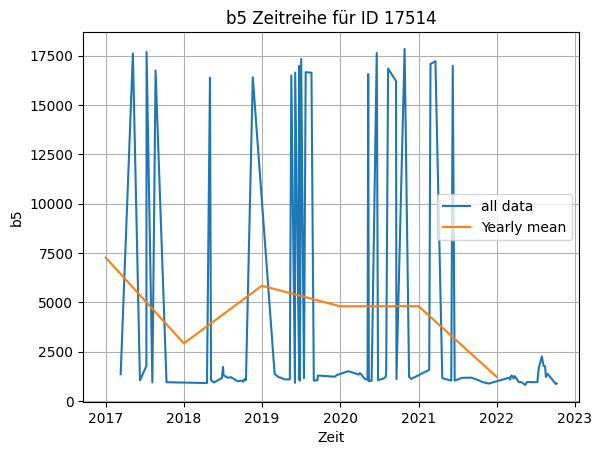

In [99]:
id = 17514
df_sub = df[df["id"] == id]

df_yearly_sub = df_yearly[df_yearly["id"] == id]
df_yearly_sub = df_yearly[df_yearly["id"] == id].copy()
df_yearly_sub["year_dt"] = pd.to_datetime(df_yearly_sub["year"].astype(str) + "-01-01")

plt.plot(df_sub["time"], df_sub[index], label="all data")
plt.plot(df_yearly_sub["year_dt"], df_yearly_sub[index], label="Yearly mean")

plt.title(f"{index} Zeitreihe für ID {id}")
plt.xlabel("Zeit")
plt.ylabel(index)
plt.legend()
plt.grid(True)
plt.show()

## Calculate std deviation for every index column
1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [100]:
indices = [
    "b2",
    "b3",
    "b4",
    "b5",
    "b6",
    "b7",
    "b8",
    "b8a",
    "b11",
    "b12",
    "ndvi",
    "gndvi",
    "wdvi",
    "tndvi",
    "savi",
    "ipvi",
    "mcari",
    "reip",
    "masvi2",
    "dvi",
]

In [101]:
df[df["mcari"] > 10000]

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
2765473,2019-12-24,4,0,358,40,117,2,180,774,821,...,0.995708,0.750533,929.0,1.222991,1.492761,0.997854,1.281600e+04,-26.700337,-0.998925,928
2013218,2019-01-20,46,0,20,25,102,0,232,1007,1174,...,1.000000,0.840125,1409.0,1.224745,1.499468,1.000000,inf,-29.692903,-0.999291,1409
2013282,2020-12-01,46,0,336,19,78,1,182,693,813,...,0.997775,0.824916,897.5,1.223836,1.495831,0.998888,2.635360e+04,-30.767123,-0.998887,897
2013303,2021-12-21,46,0,355,51,83,0,89,471,623,...,1.000000,0.764873,518.0,1.224745,1.498554,1.000000,inf,-31.018325,-0.998071,518
1184897,2022-01-12,68,0,12,172,76,2,260,467,548,...,0.993691,0.756410,631.0,1.222166,1.489362,0.996845,2.683200e+04,-50.628019,-0.998419,630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158073,2021-11-11,28169,0,315,92,108,3,199,950,1156,...,0.995458,0.829114,1316.5,1.222889,1.492622,0.997729,1.040107e+04,-30.038615,-0.999242,1315
2624250,2018-12-24,28173,0,358,100,196,6,320,1214,1552,...,0.992736,0.775744,1643.0,1.221776,1.488654,0.996368,1.339733e+04,-34.161074,-0.999393,1640
2624311,2020-12-26,28173,0,361,102,120,1,291,1314,1521,...,0.998807,0.853748,1675.5,1.224258,1.497765,0.999404,6.751200e+04,-29.316716,-0.999404,1675
3272548,2022-01-15,28200,0,15,99,195,11,383,1346,1530,...,0.987457,0.773913,1737.5,1.219614,1.480764,0.993729,1.036189e+04,-31.218069,-0.999426,1732


In [102]:
# scaler = MinMaxScaler()
# df_norm = df.copy()
# df_norm[indices] = scaler.fit_transform(df[indices])

In [103]:
df_yearly = df_norm.groupby(["id", "year"])[indices].mean().reset_index()
std_df = df_yearly.groupby("id")[indices].std().reset_index()
std_df = std_df.rename(columns={col: f"{col}_stdv" for col in indices})

df_disturbance = df.groupby("id")["is_disturbed"].first().reset_index()
std_df = std_df.merge(df_disturbance, on="id", how="left")

## Correlation between features and disturbance

In [104]:
results = []

for col in [c for c in std_df.columns if c.endswith("_stdv")]:
    r, p = pointbiserialr(std_df["is_disturbed"].astype(int), std_df[col])
    results.append({"feature": col, "correlation": r, "p_value": p})

results_df = pd.DataFrame(results).sort_values(by="correlation", ascending=False)

results_df

,feature,correlation,p_value
8,b11_stdv,0.639905,0.000000e+00
9,b12_stdv,0.600500,0.000000e+00
3,b5_stdv,0.559458,0.000000e+00
10,ndvi_stdv,0.552829,0.000000e+00
15,ipvi_stdv,0.552829,0.000000e+00
14,savi_stdv,0.552762,0.000000e+00
13,tndvi_stdv,0.539855,0.000000e+00
11,gndvi_stdv,0.521189,0.000000e+00
2,b4_stdv,0.492968,0.000000e+00
1,b3_stdv,0.469568,0.000000e+00


In [105]:
std_df.corr()["is_disturbed"].sort_values(ascending=False)
# Fazit: Spalten mit corr > 0.25 verwenden

is_disturbed    1.000000
b11_stdv        0.639905
b12_stdv        0.600500
b5_stdv         0.559458
ndvi_stdv       0.552829
ipvi_stdv       0.552829
savi_stdv       0.552762
tndvi_stdv      0.539855
gndvi_stdv      0.521189
b4_stdv         0.492968
b3_stdv         0.469568
b2_stdv         0.405810
b6_stdv         0.393784
b8a_stdv        0.393101
b8_stdv         0.376689
b7_stdv         0.351447
wdvi_stdv       0.307840
dvi_stdv        0.259156
reip_stdv       0.063721
masvi2_stdv     0.050142
mcari_stdv      0.034618
id             -0.008497
Name: is_disturbed, dtype: float64

In [106]:
# auch Abweichung eines Features im Vergleich zu gleichen Bäumen ist Indikator für Disturbance

## Change Point Detection

In [107]:
# Idee: Methoden verwenden wie Change Point Detecttion oder eine Trendanalyse
# (beides vllt da manchmal plötzliche änderung, oder auch stetig sinkend)